In [2]:
# create a model that uses the fenchel-young loss and trains on 200 images 
# the images are permuted in 9 tiles and in every iteration a new permutation is generated.
# we use a deep encoder with fixed parameters, adam optimizer, preprocessing before tiling  

import tensorflow as tf

2022-10-27 11:20:59.854421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import platform
import cv2
import numpy as np
import os
from pathlib import Path

number_of_images = 250

root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) 
if platform.system()=='Darwin':
  root = os.getcwd() # Don't change this
  data_dirname = '/data_test/plantvillage/' # Change as you like 
  p = Path(root + data_dirname)
  p.mkdir(exist_ok=True) 
else:
  p = Path("C:/Users/mwels/Documents/Uni/11. Semester/Deep learning in visual recognition/Plant_leave_diseases_dataset_without_augmentation")
  p.mkdir(exist_ok=True)


classes = [
  'Apple___Apple_scab',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  "all"
  ]

if "all" in classes:
  classes = os.listdir(p)

for c in classes:
  print(c,end=" ")
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))


filelist = filelist[:number_of_images]
print(len(filelist))

Apple___Cedar_apple_rust Apple___Apple_scab Apple___Black_rot Apple___healthy 250


In [4]:
len(filelist)

250

In [5]:
tilex = 3
number_of_tiles = tilex**2
tile_size = 255//tilex

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(tile_size, tile_size, 3))

In [6]:
from keras.layers import Dense, Concatenate, Input, Flatten, Lambda 
from keras.models import Model
import os


tiles = Input((number_of_tiles,tile_size,tile_size,3))
layers = {}
embedds = {}

shared_conv = conv_base 

for i in range(number_of_tiles):
    layers[f'tile{i}'] = Lambda(lambda x: x[:,i,:,:,:])(tiles)

    layers[f'deep_layers{i}'] = shared_conv(layers[f'tile{i}'])
    embedds[f'embedd{i}'] = Flatten()(layers[f'deep_layers{i}'])

concatonation = Concatenate(axis=1)(list(embedds.values()))

out = Dense(number_of_tiles*10, activation="relu", kernel_initializer='he_normal')(concatonation)
out = Dense(number_of_tiles, kernel_initializer='he_normal')(out)
out = Flatten()(out)

model = Model(inputs=tiles, outputs=out)

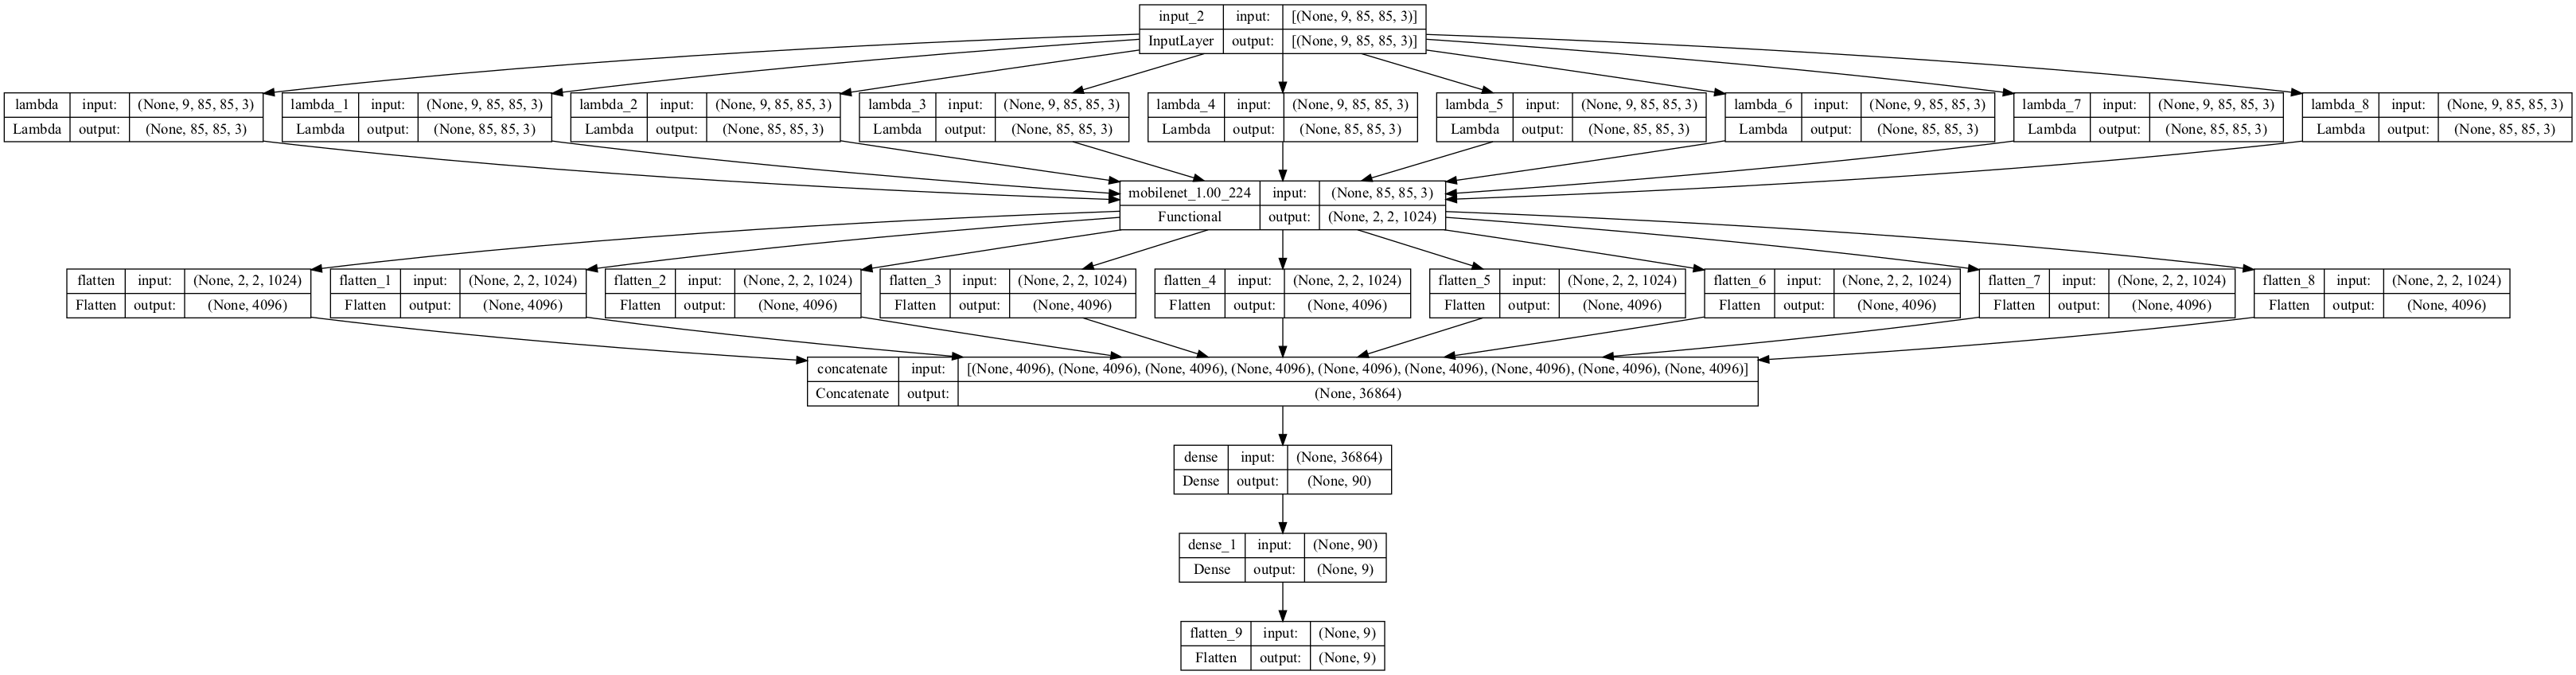

In [7]:
tf.keras.utils.plot_model(model, 
    show_shapes=True)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9, 85, 85,   0           []                               
                                3)]                                                               
                                                                                                  
 lambda (Lambda)                (None, 85, 85, 3)    0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 85, 85, 3)    0           ['input_2[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 85, 85, 3)    0           ['input_2[0][0]']            

In [9]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 24
Number of pretrained base layers is 86


In [10]:
sys.path.append('src')

In [18]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.PermOneHotDataGen import *
from src.model_tools import *
from src.permutation_tools import *

x_train, x_test = train_test_split(filelist)

train_generator = PermOneHotDataGen(x_train,
                                    batch_size=8,
                                    tilenumberx=tilex, 
                                    shuffle_permutations=True)

validation_generator = PermOneHotDataGen(x_test,
                                        batch_size=8,
                                        tilenumberx=tilex,
                                        shuffle_permutations=True)

train_generator_old = PermNetDataGenerator(x_train,
                                    batch_size=8,
                                    tilenumberx=tilex)

validation_generator_old = PermNetDataGenerator(x_test,
                                        batch_size=8,
                                        tilenumberx=tilex)


optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)


model.compile(
    optimizer=optimizer,
    loss=RankingLoss(),
    metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])

In [19]:
print(train_generator.next()[1].shape)
print(train_generator_old.next()[1].shape)
print(validation_generator.next()[1].shape)
print(validation_generator_old.next()[1].shape)

(8, 9)
(8, 9)
(8, 9)
(8, 9)


In [20]:
ProjectedRanksAccuracy().update_state(validation_generator.next()[1], validation_generator.next()[1])

In [21]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [22]:
nb_epochs = 30

model.fit(train_generator,
          epochs = nb_epochs,
          validation_data=validation_generator,
          verbose=1)

Epoch 1/30
24/24 [==============================] - 124s 5s/step - loss: 957.1338 - projection_ranks_acc: 0.6987 - partial_ranks_acc: 0.0961 - val_loss: 926.6743 - val_projection_ranks_acc: 0.7074 - val_partial_ranks_acc: 0.0935
Epoch 2/30
24/24 [==============================] - 87s 4s/step - loss: 946.8931 - projection_ranks_acc: 0.7028 - partial_ranks_acc: 0.0957 - val_loss: 960.1566 - val_projection_ranks_acc: 0.6970 - val_partial_ranks_acc: 0.1138
Epoch 3/30
24/24 [==============================] - 83s 3s/step - loss: 914.1725 - projection_ranks_acc: 0.7126 - partial_ranks_acc: 0.1086 - val_loss: 934.1590 - val_projection_ranks_acc: 0.7042 - val_partial_ranks_acc: 0.1146
Epoch 4/30
24/24 [==============================] - 86s 4s/step - loss: 945.5104 - projection_ranks_acc: 0.7029 - partial_ranks_acc: 0.1001 - val_loss: 978.2024 - val_projection_ranks_acc: 0.6916 - val_partial_ranks_acc: 0.1064
Epoch 5/30
24/24 [==============================] - 82s 3s/step - loss: 970.5084 - proj

KeyboardInterrupt: 

In [23]:
model.save("models/2022_10_27__01")

INFO:tensorflow:Assets written to: models/2022_10_27__01/assets


INFO:tensorflow:Assets written to: models/2022_10_27__01/assets
